In [1]:
import warnings
import pickle
warnings.filterwarnings('ignore')

from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing.reweighing import Reweighing

import numpy as np
import pandas as pd
import source.fairness as fm

from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


In [14]:
with open ('data/census_income/census_income.pkl', 'rb') as f:
    dic = pickle.load(f)

X_train, S_train, Y_train = dic['train']
X_test, S_test, Y_test = dic['test']

numerical, nominal = dic['features'][0], dic['features'][1]
features = numerical + nominal + ['sex'] + ['label']
privileged_groups = [{'sex': 0}]
unprivileged_groups = [{'sex': 1}]

dataset_orig_train = np.hstack((X_train.toarray(), S_train.reshape(-1,1), Y_train.reshape(-1,1)))
dataset_orig_train = pd.DataFrame(dataset_orig_train, columns=features)
dataset_orig_train = StandardDataset(df=dataset_orig_train,
                                     label_name='label',
                                     favorable_classes=[1],
                                     protected_attribute_names=['sex'],
                                     privileged_classes=[[0]])


In [15]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

lmod_RW = SGDClassifier(loss='log_loss')
lmod_RW.fit(X_train, Y_train, 
         sample_weight=dataset_transf_train.instance_weights)
perceptron_RW = SGDClassifier(loss='perceptron')
perceptron_RW.fit(X_train, Y_train, 
         sample_weight=dataset_transf_train.instance_weights)

lmod = SGDClassifier(loss='log_loss')
lmod.fit(X_train, Y_train)
perceptron = SGDClassifier(loss='perceptron')
perceptron.fit(X_train, Y_train)


y_test_lmod_pred_weight = lmod_RW.predict(X_test)
y_test_perceptron_pred_weight = perceptron_RW.predict(X_test)
y_test_lmod_pred = lmod.predict(X_test)
y_test_perceptron_pred = perceptron.predict(X_test)


In [19]:
predictions = {
    'LR': {
        'original': y_test_lmod_pred,
        'reweighing': y_test_lmod_pred_weight},
    'Perceptron': {
        'original': y_test_perceptron_pred,
        'reweighing': y_test_perceptron_pred_weight}
}

results = pd.DataFrame()

for m in predictions:
    for t in predictions[m]:
        for metric in ['eq_opp', 'eq_odds', 'dem_p']:
            if metric =='eq_opp':
                value = fm.equal_opp_dif(Y_test, predictions[m][t],S_test, 1, 0)
            elif metric == 'eq_odds':
                value = fm.equal_odd_dif(Y_test, predictions[m][t], S_test, 1, 0)
            else:
                value = fm.demographic_parity_dif(predictions[m][t], S_test, 1, 0)
            
            results = pd.concat([results, pd.DataFrame({'type': t,
                                                        'model': m,
                                                        'fairness metric': metric,
                                                        'abs(disparity)': abs(value)
                                                        }, index=[0])
                                ], axis=0)

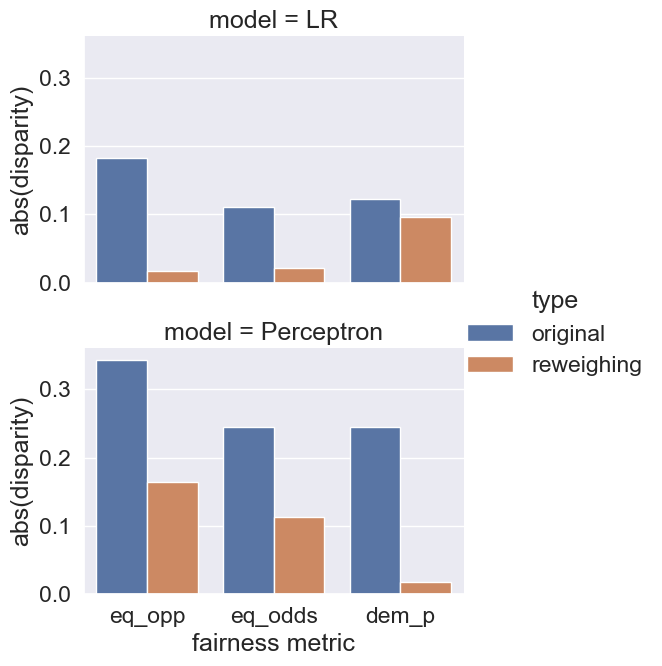

In [20]:
sns.set(font_scale=1.5)
sns.catplot(x="fairness metric", 
            y="abs(disparity)", 
            hue="type", 
            row="model",
            kind="bar", 
            height=3.5, aspect=1.5,
            data=results)
            
plt.show()